In [7]:
!pip install -qU langchain tiktoken matplotlib seaborn tqdm pypdf

In [8]:
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import PyPDFLoader

In [9]:
path = './SourceData'
loader = DirectoryLoader(path, glob="**/*.pdf", loader_cls=PyPDFLoader)

In [10]:
docs = loader.load()

In [12]:
len(docs)

7

In [13]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [14]:
tiktoken.encoding_for_model('gpt-3.5-turbo')

<Encoding 'cl100k_base'>

In [15]:
docs[0].page_content

'embeddings operations.\nAugment ed data included with pr ompts . When using the "on your data" feature,\nthe service retrieves relevant data from a configured data store and augments the\nprompt to produce generations that are grounded with your data.\nTraining & v alidation data . You can provide your own training data consisting of\nprompt-completion pairs for the purposes of fine-tuning an OpenAI model .\nThe diagram below illustrates how your data is processed. This diagram covers three\ndifferent types of processing:\n1. How the Azure OpenAI Service processes your prompts to generate content\n(including when additional data from a connected data source is added to a\nprompt using Azure OpenAI on your data).\n2. How the Azure OpenAI Service creates a fine-tuned (custom) model with your\ntraining data.\n3. How the Azure OpenAI Service and Microsoft personnel analyze prompts,\ncompletions and images for harmful content and for patterns suggesting the use\nof the service in a manner 

In [16]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

In [17]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 0
Avg: 251
Max: 526


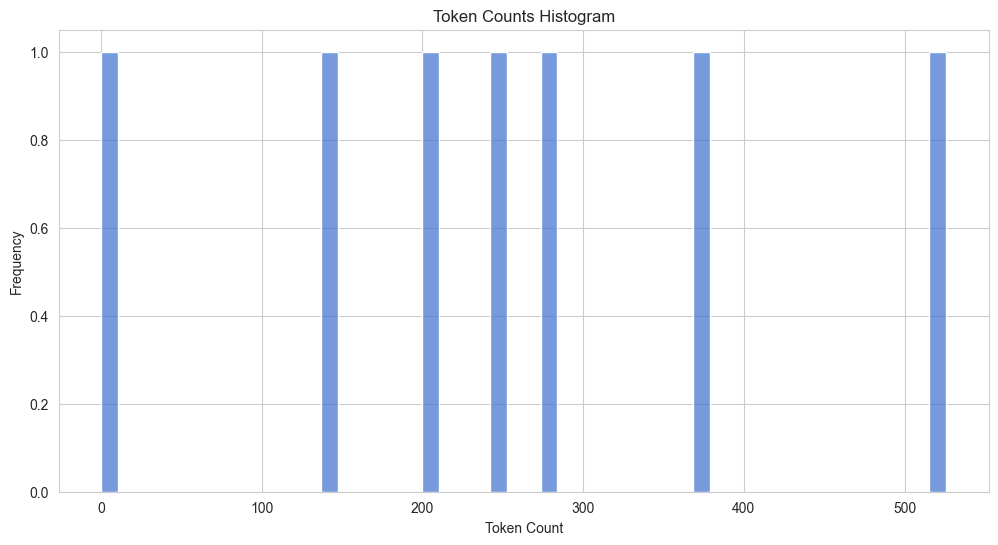

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

In [19]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

In [23]:
chunks = text_splitter.split_text(docs[5].page_content)
len(chunks)

1

In [25]:
tiktoken_len(chunks[0])

136

In [27]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

path = docs[5].metadata['source']
print(path)

# convert URL to unique ID
m.update(url.encode('utf-8'))
uid = m.hexdigest()[:12]
print(uid)

SourceData\DPS_Openai_Docs.pdf
ebe7afbc5ca1


In [28]:
data = [
    {
        'id': f'{uid}-{i}',
        'text': chunk,
        'source': path
    } for i, chunk in enumerate(chunks)
]
data

[{'id': 'ebe7afbc5ca1-0',
  'text': 'Dat e Changes\n23\nJune\n2023Added information about data processing for new Azure on your data feature; removed\ninformation about abuse monitoring which is now available at Azure OpenAI Service\nabuse monitoring . Added summary note. Updated and streamlined content and\nupdated diagrams for additional clarity. added change log\nLimited access to Azure OpenAI Service\nCode of conduct for Azure OpenAI Service integrations\nTransparency note and use cases for Azure OpenAI Service\nCharacteristics and limitations for Azure OpenAI Service\nReport abuse of Azure OpenAI Service through the Report Abuse P ortal\nReport problematic content to cscraireport@microsoft.comChange log\nSee also',
  'source': 'SourceData\\DPS_Openai_Docs.pdf'}]

In [29]:
from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    path = doc.metadata['source']
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': path
        })

len(documents)

  0%|          | 0/7 [00:00<?, ?it/s]

7

In [30]:
import json

with open('TrainData/train.jsonl', 'w') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')